# Detecção de retas e círculos com a Transformada de Hough

A **Transformada de Hough** é uma metodologia capaz de fazer a detecção de objetos baseados em figuras geométricas ou em uma nuvem de pontos. O OpenCV implementa a Transformada de Hough para a detecção de lihas retas e círculos. 

## Detecção de retas

Para detectar as retas, a transformada de Hough levanta todas as possíveis retas que passam por um determinado ponto de borda, representadas por seus parâmetros $\rho$ e $\theta$. Os parâmetros dessas retas recebem um voto em uma *matriz de votação*, ou *acumulador*. Quanto mais pontos uma determinada reta pode cruzar, mais votos seus parãmetros receberão.

Vamos analisar a matriz de votação resultante das imagens abaixo


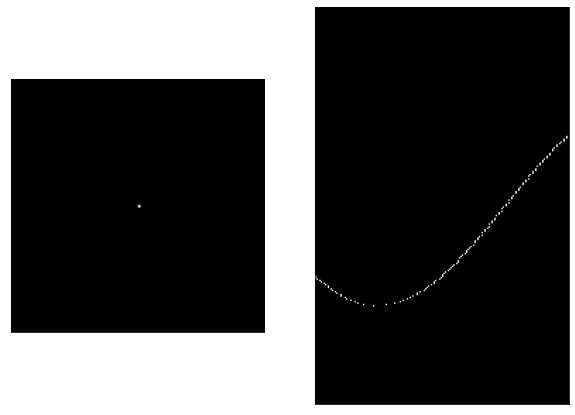

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from hough_helper import mostra_imagem
from hough_helper import acumulador_hough_retas

# Imagem com apenas um ponto
h = 100
w = 100
img1 = np.zeros((h, w), dtype=np.uint8)
img1[h//2, w//2] = 255
votes1 = acumulador_hough_retas(img1, 1, np.pi/180) 
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
mostra_imagem(img1, subfig=True)
plt.subplot(1, 2, 2)
mostra_imagem(votes1)

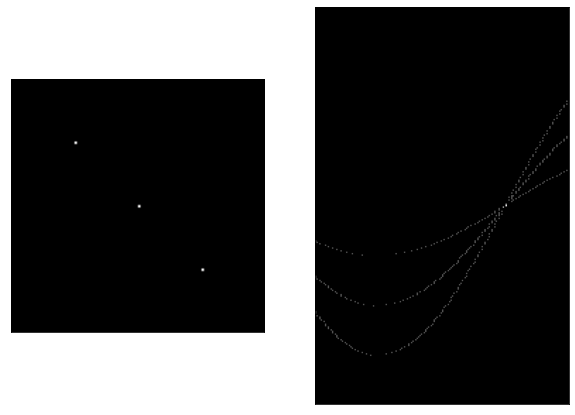

In [2]:
# Imagem com três pontos colineares
img2 = np.zeros((h, w), dtype=np.uint8)
img2[h//4, w//4] = 255
img2[h//2, w//2] = 255
img2[3*h//4, 3*w//4] = 255

votes2 = acumulador_hough_retas(img2, 1, np.pi/180) 

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
mostra_imagem(img2, subfig=True)
plt.subplot(1, 2, 2)
mostra_imagem(votes2)

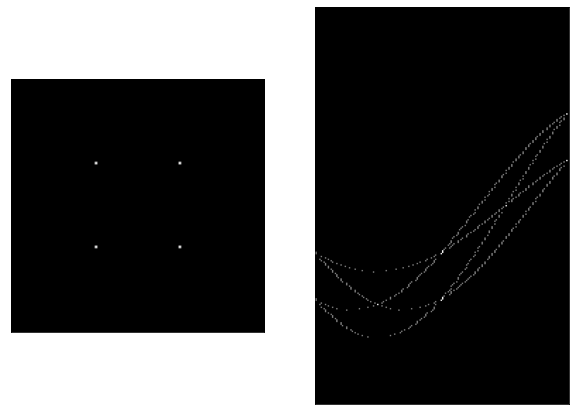

In [3]:
# Imagem com quatro pontos (retângulo)
img3 = np.zeros((h, w), dtype=np.uint8)
img3[h//3, w//3] = 255
img3[2*h//3, w//3] = 255
img3[h//3, 2*w//3] = 255
img3[2*h//3, 2*w//3] = 255
votes3 = acumulador_hough_retas(img3, 1, np.pi/180) 

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
mostra_imagem(img3, subfig=True)
plt.subplot(1, 2, 2)
mostra_imagem(votes3)

### Encontrando os pontos de borda

Detecção de Bordas é uma das operações fundamentais quando trabalhamos com processamento de imagens, consistindo na identificação de mudanças locais significativas nos níveis de cinza da imagem. Essas mudanças podem ser descritas po meio do conceito de derivada. Como uma imagem depende de duas coordenadas espaciais (x e y), as bordas da imagem podem ser expressas por derivadas parciais. Um operador muito utilizado na diferenciação de imagens é o <b>gradiente</b>, que é um vetor cuja direção indica os locais nos quais os níveis de cinza sofrem maior variação.

#### a) Máscaras do gradiente de Sobel
Os operadores de Sobel são uma junção de suavização Gaussiana com operação de diferenciação, de modo que são mais resistentes a ruído. Você pode especificar a direção das derivadas a serem tomadas -- vertical ou horizontal (pelos argumentos, `yorder` e `xorder`, respectivamente). Você pode também especificar o tamanho do kernel pelo argumento `ksize`. 

O operador de Sobel aproxima a magnitude do gradiente como a diferença de valores ponderados dos níveis de cinza pelas seguintes máscaras: 

              | -1  0  1 |              |-1 -2 -1 |
       Gx  =  | -2  0  2 |       Gy  =  | 0  0  0 |
              | -1  0  1 |              | 1  2  1 |
      
A magnitude final do gradiente é obtido pela dos módulos das imagens produzidas por Gx e Gy. 

Veja o código:



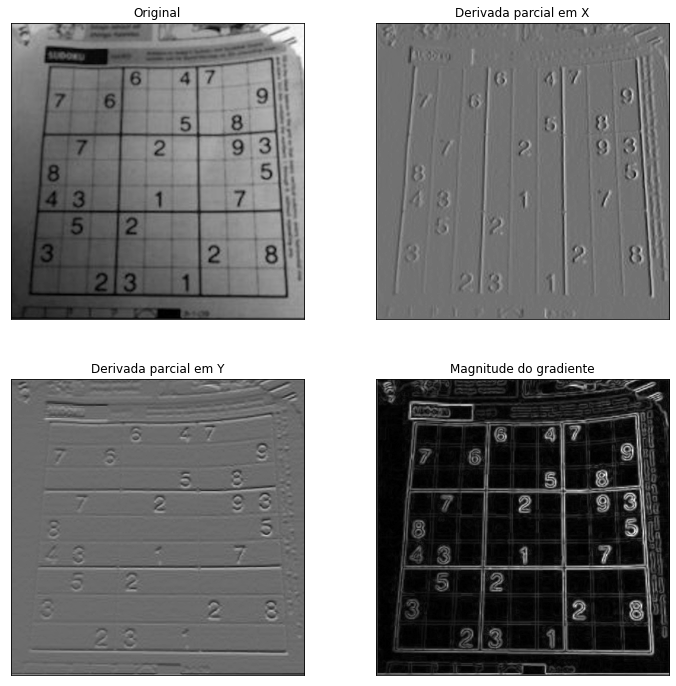

In [4]:
import cv2
from hough_helper import mostra_imagem

def magnitude_do_gradiente(img, showfig=False):
    
    # Filtro de Sobel para a derivada ao longo de X
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0)

    # Filtro de Sobel para a derivada ao longo de Y
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1)
    
    # Magnitude do gradiente
    mag_gradiente = (sobelx**2 + sobely**2)**0.5
    
    # Converte a imagem de ponto flutuante de 64 bits para imagem de 8 bits
    mag_gradiente = cv2.convertScaleAbs(mag_gradiente) 
    
    if showfig: 
        plt.figure(figsize=(12,12))
        plt.subplot(2,2,1)
        mostra_imagem(img, 'Original', subfig=True)
        plt.subplot(2,2,2)
        mostra_imagem(sobelx, 'Derivada parcial em X', subfig=True)
        plt.subplot(2,2,3)
        mostra_imagem(sobely, 'Derivada parcial em Y', subfig=True)
        plt.subplot(2,2,4)
        mostra_imagem(mag_gradiente, 'Magnitude do gradiente')
    
    return mag_gradiente

img = cv2.imread('dave.jpg',cv2.IMREAD_GRAYSCALE)
mag_gradiente = magnitude_do_gradiente(img, showfig=True)


#### b) Encontrando as bordas por limiiarização

Uma das aplicações mais importantes dos filtros de gradiente é a detecção de bordas. Os filtros de gradiente como Sobel e Prewitt favorecem bordas com alguma direção preferencial, enquanto filtros isotrópicos (com as mesmas propriedades em qualquer direção) como o Laplaciano e o passa-altas básico favorecem pontos que se destacam da imagem.

Sendo assim, a melhor forma de realçarmos as bordas dos objetos usando filtros é através da **magnitude do gradiente**. Uma vez tendo realizado essa operação, podemos identificar os pontos de borda de forma simples através da operação de limiarização, ou *thresholding* 


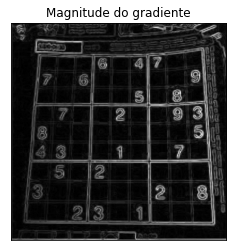

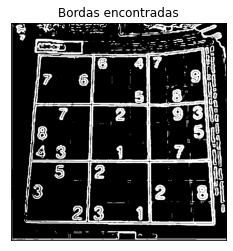

In [5]:
# Encontra as bordas na imagem da magnitude do gradiente
threshold_value = 50
retval, bordas = cv2.threshold(mag_gradiente, threshold_value, 255, cv2.THRESH_BINARY)
mostra_imagem(mag_gradiente, 'Magnitude do gradiente')
mostra_imagem(bordas, 'Bordas encontradas')

## Uso da função HoughLines


O uso básico da função para a detecção de retas com a Transformada de Hough é:

    lines = cv2.HoughLines( image, rho, theta, threshold )
    

- `image`: Imagem de 8 bits contendo os pontos de borda na cor branca
- `lines`: Matriz de saída das linhas detectadas. Cada linha da matriz contém 2 elementos (ρ,θ):
    + `ρ` é a distancia da reta à origem das coordenadas (0,0)
    + `θ` é o ângulo da reta
- `rho`: Resolução da distância em pixels. 1 pixel está OK.
- `theta`: Resolução do ângulo em radiandos. 1 grau está OK.
- `threshold`: Limiar de detecção da reta. São retornadas apenas aquelas retas com número suficiente de votos (>`threshold`).

Vejamos o exemplo com a imagem de bordas acima














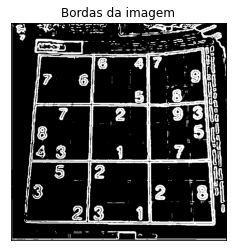

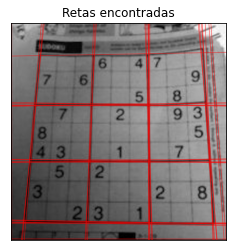

In [6]:
from hough_helper import desenha_retas

lines = cv2.HoughLines(bordas, 1, np.pi/180, 500) 
img_retas = desenha_retas(img, lines)

mostra_imagem(bordas, "Bordas da imagem")
mostra_imagem(img_retas, "Retas encontradas")


## A função HoughLinesP

É uma implementação eficiente da função HoughLines ([ver explicação](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)). Em vez de retornar os parâmetros da treta, retorna uma lista de segmentos de reta identificados pelos pontos inicial e final.


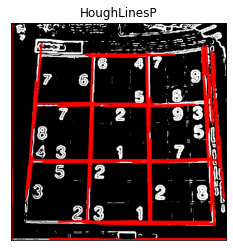

In [17]:
50
lines = cv2.HoughLinesP(bordas, 10, math.pi/180.0, threshold=500, minLineLength=100, maxLineGap=5)

a,b,c = lines.shape

hough_img_rgb = cv2.cvtColor(bordas, cv2.COLOR_GRAY2BGR)

for i in range(a):
    # Faz uma linha ligando o ponto inicial ao ponto final, com a cor vermelha (BGR)
    cv2.line(hough_img_rgb, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 5, cv2.LINE_AA)
    
mostra_imagem(hough_img_rgb, "HoughLinesP")

## Encontrando circunferências na imagem

A implementação da transformada de Hough para encontrar circunferências emprega algumas otimizações que tornam desnecessário encontrar as bordas da imagem antes. No entanto, se usarmos a imagem resultante da magnitude do gradiente, teremos um melhor resultado, pois as bordas estarão mais detacadas. Outras melhorias que podemos aplicar antes do realce das bordas são:

- Leve redução do contraste para equilibrar a iluminação na imagem
- Uso do filtro da mediana para atenuação de ruído

O uso básico da função para a detecção de circunferências com a Transformada de Hough é:
    
    circles = cv2.HoughCircles(image, method, dp, minDist, param1, param2, minRadius, maxRadius)

- `image`: Imagem de 8 bits onde as circunferências serão procuradas
- `method`: método usado para encontrar os possíveis centros de cada circunferência. Aqui vamos usar `cv2.HOUGH_GRADIENT`.
- `dp`: resolução usada na procura pelos centros das circunferências
- `minDist`: menor distância permitida entre os centros das circunferências encontradas
- `param1`: limiar empregado na detecção dos pontos de borda
- `param2`: limiar de detecção da circunferência
- `minRadius`: menor raio da circunferência a ser encontradas
- `maxRadius`: maior raio da circunferência a ser encontradas

Veja o exemplo do uso da função na imagem das bordas realçadas acima


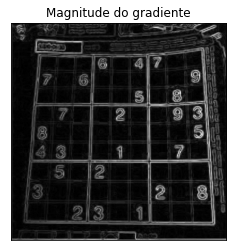

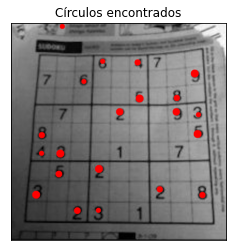

In [21]:

from hough_helper import desenha_circulos

circles = cv2.HoughCircles(mag_gradiente, method=cv2.HOUGH_GRADIENT, dp=1, minDist=30, param1=110, param2=20, minRadius=8, maxRadius=15)
img_circles = desenha_circulos(img, circles)

mostra_imagem(mag_gradiente, "Magnitude do gradiente")
mostra_imagem(img_circles, "Círculos encontrados")




